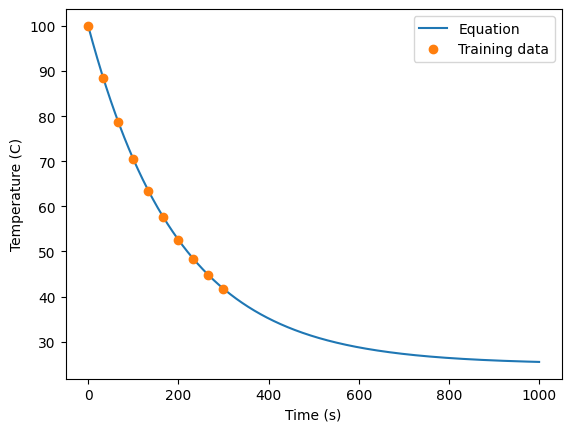

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint

class Data:
    def __init__(self, Tenv=25, T0=100, R=0.005):
        self.Tenv = Tenv
        self.T0 = T0
        self.R = R
        
        self.times = np.linspace(0, 1000, 1000)
    
    def cooling_law(self, t):
        return self.Tenv + (self.T0 - self.Tenv) * np.exp(-self.R * t)
    
    def ode_func(self, t, y):
        dydt = self.R * (self.Tenv - y)
        return dydt
    
    def solve_ode(self):
        return solve_ivp(self.ode_func, [0, 1000], [self.T0], t_eval=self.times)
    
    def train_data(self):
        t_train = np.linspace(0, 300, 10)
        y_train = self.cooling_law(t_train)
        return t_train, y_train
    
data = Data()
y_true = data.cooling_law(data.times)
t_train, y_train = data.train_data()

# Plot solution
plt.plot(data.times, y_true, label='Equation')
plt.plot(t_train, y_train, 'o', label='Training data')
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

t_train_ts = torch.tensor(t_train, dtype=torch.float32).reshape(-1, 1)
y_train_ts = torch.tensor(y_train, dtype=torch.float32).view(-1,1)

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc  = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc(x))
        x = self.fc2(x)
        return x

In [22]:
physics = True

def physics_loss(model: nn.Module):
    t = np.linspace(0, 1000, 1000)
    t_ts = torch.tensor(t, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    y_pred_ts = model(t_ts)
    dy_pred_ts_dt = torch.autograd.grad(y_pred_ts, t_ts, torch.ones_like(y_pred_ts), create_graph=True)[0]
    error = dy_pred_ts_dt - data.R * (data.Tenv - y_pred_ts)
    return torch.mean(error**2)

In [25]:
model = NN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

model.train()
for epoch in range(30000):
    optimizer.zero_grad()
    y_pred = model(t_train_ts)
    
    loss = criterion(y_pred, y_train_ts)
    
    if physics:
        loss_ode = physics_loss(model)
        loss += loss_ode

    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')

Epoch 0, Loss 4541.25390625
Epoch 1000, Loss 343.9734191894531
Epoch 2000, Loss 37.170101165771484
Epoch 3000, Loss 1.201607584953308
Epoch 4000, Loss 0.008689090609550476
Epoch 5000, Loss 0.0006520827300846577
Epoch 6000, Loss 0.00040810141945257783
Epoch 7000, Loss 0.40052899718284607
Epoch 8000, Loss 0.00040384940803050995
Epoch 9000, Loss 0.0010234246728941798
Epoch 10000, Loss 0.00019314905512146652
Epoch 11000, Loss 0.000170066487044096
Epoch 12000, Loss 0.0001632154599064961
Epoch 13000, Loss 9.266231791116297e-05
Epoch 14000, Loss 5.159107968211174e-05
Epoch 15000, Loss 2.3461969249183312e-05
Epoch 16000, Loss 1.081280061043799e-05
Epoch 17000, Loss 0.00032383520738221705
Epoch 18000, Loss 0.0006649756105616689
Epoch 19000, Loss 2.7711950679076836e-05
Epoch 20000, Loss 6.320778538793093e-06
Epoch 21000, Loss 0.0003660556976683438
Epoch 22000, Loss 5.099739155411953e-06
Epoch 23000, Loss 0.014783809892833233
Epoch 24000, Loss 6.079566810512915e-05
Epoch 25000, Loss 3.98186966776

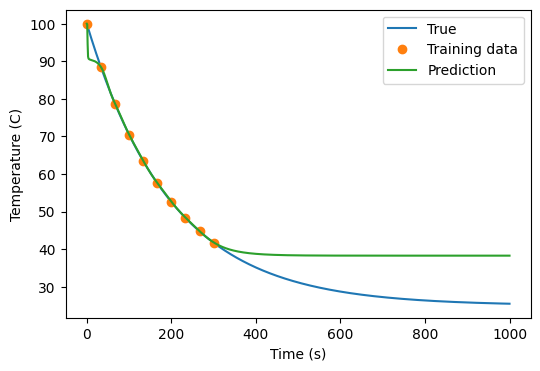

In [27]:
def evaluation(model: nn.Module):
    model.eval()
    t_test = np.linspace(0, 1000, 1000)
    y_test = data.cooling_law(t_test)
    t_test_ts = torch.tensor(t_test, dtype=torch.float32).reshape(-1, 1)
    y_pred_ts = model(t_test_ts)
    y_pred = y_pred_ts.detach().numpy()
    
    plt.figure(figsize=(6,4))
    plt.plot(t_test, y_test, label='True')
    plt.plot(t_train, y_train, 'o', label='Training data')
    plt.plot(t_test, y_pred, label='Prediction')
    plt.ylabel('Temperature (C)')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.show()
    
    
evaluation(model)
    